In [1]:
%load_ext autoreload
%autoreload 2

import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

sc.set_figure_params(figsize=(4, 4))

/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/traitlets/traitlets.py:3030: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


In [2]:
# Load the TCR data
adata_tcr = ir.io.read_10x_vdj(
    "example_data/liao-2019-covid19/GSM4385993_C144_filtered_contig_annotations.csv.gz"
)

# Load the associated transcriptomics data
adata = sc.read_10x_h5(
    "example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5"
)

This particular sample only has a detected TCR for a small fraction of the cells:

In [3]:
adata_tcr.shape

(136, 0)

In [4]:
adata.shape

(3716, 33539)

In [5]:
ir.pp.merge_with_ir(adata, adata_tcr)

Now, we can use TCR-related variables together with the gene expression data.
Here, we visualize the cells with a detected TCR on the UMAP plot.
It is reassuring that the TCRs coincide with the T-cell marker gene CD3.

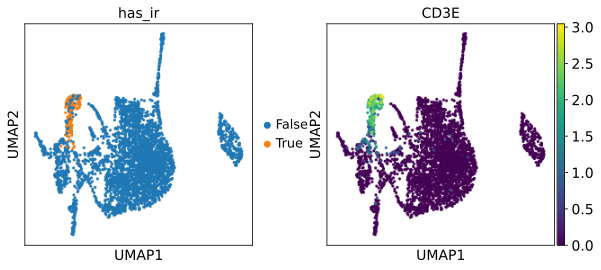

In [6]:
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_ir", "CD3E"])

In [7]:
# extract data
with tarfile.open("example_data/chung-park-2017.tar.bz2", "r:bz2") as tar:
    tar.extractall("example_data/chung-park-2017")

In [8]:
# Load transcriptomics data from count matrix
expr_chung = pd.read_csv("example_data/chung-park-2017/counts.tsv", sep="\t")
# anndata needs genes in columns and samples in rows
expr_chung = expr_chung.set_index("Geneid").T
adata = sc.AnnData(expr_chung)
adata.shape

(563, 23438)

In [9]:
# Load TCR data and merge it with transcriptomics data
adata_tcr = ir.io.read_tracer("example_data/chung-park-2017/tracer/")
ir.pp.merge_with_ir(adata, adata_tcr)

/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


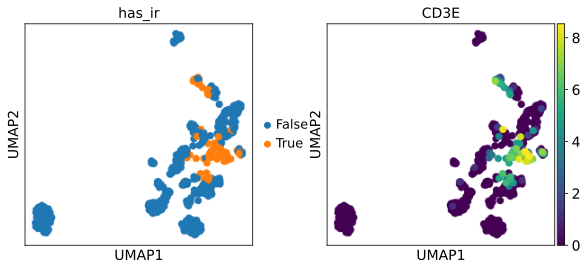

In [10]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_ir", "CD3E"])

In [11]:
adata = ir.io.read_airr(
    [
        "example_data/immunesim_airr/immunesim_tra.tsv",
        "example_data/immunesim_airr/immunesim_trb.tsv",
    ]
)
ir.tl.chain_qc(adata)

In [12]:
ir.pp.ir_dist(adata, metric="alignment", sequence="aa", cutoff=25)

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  7.36it/s]

100%|██████████| 3/3 [00:00<00:00, 21.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  7.41it/s]

100%|██████████| 3/3 [00:00<00:00, 22.09it/s]

0it [00:00, ?it/s]

49it [00:00, 484.30it/s]

98it [00:00, 450.92it/s]

100it [00:00, 454.35it/s]

<AxesSubplot:title={'center':'cc_aa_alignment'}>

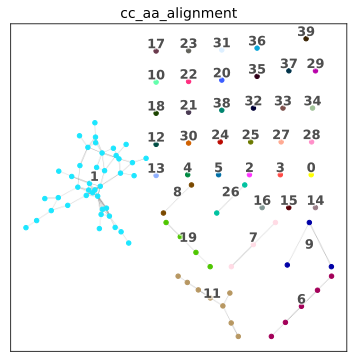

In [13]:
ir.tl.define_clonotype_clusters(
    adata,
    metric="alignment",
    sequence="aa",
    receptor_arms="any",
    dual_ir="primary_only",
)
ir.tl.clonotype_network(adata, size_aware=False, metric="alignment", sequence="aa")
ir.pl.clonotype_network(
    adata,
    color="cc_aa_alignment",
    base_size=20,
    panel_size=(6, 6),
    show_legend=False,
    show_size_legend=False,
)

In [14]:
tcr_table = pd.read_csv(
    "example_data/chung-park-2017/tcr_table.tsv",
    sep="\t",
    index_col=0,
    na_values=["None"],
    true_values=["True"],
)
tcr_table

,cell_id,cdr3_alpha,cdr3_nt_alpha,count_alpha,v_alpha,j_alpha,cdr3_beta,cdr3_nt_beta,count_beta,v_beta,d_beta,j_beta,productive_alpha,productive_beta
0,SRR2973278,AVSDIHASGGSYIPT,GCTGTTTCGGATATTCATGCATCAGGAGGAAGCTACATACCTACA,9.29463,TRAV21,TRAJ6,ASSWWQNTEAF,GCCAGCAGCTGGTGGCAGAACACTGAAGCTTTC,37.5984,TRBV5-1,NaN,TRBJ1-1,True,True
1,SRR2973305,AVVTGANSKLT,GCTGTGGTAACTGGAGCCAATAGTAAGCTGACA,89.45740,TRAV22,TRAJ56,NaN,NaN,NaN,NaN,NaN,NaN,True,True
2,SRR2973371,ALKRTGNTPLV,GCTCTGAAAAGAACAGGAAACACACCTCTTGTC,431.96500,TRAV9-2,TRAJ29,ASRSRDSGEPQH,GCCAGCAGGAGCAGGGACAGCGGAGAGCCCCAGCAT,952.0230,TRBV10-2,TRBD1,TRBJ1-5,True,True
3,SRR2973377,ATDPETSGSRLT,GCTACGGACCCAGAAACCAGTGGCTCTAGGTTGACC,772.43600,TRAV17,TRAJ58,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,SRR2973403,AVRGATDSWGKFQ,GCTGTGAGAGGAGCAACTGACAGCTGGGGGAAATTCCAG,95.63640,TRAV3,TRAJ24,SVQTSEYEQY,AGCGTCCAGACTAGCGAGTACGAGCAGTAC,205.8330,TRBV29-1,TRBD2,TRBJ2-7,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,SRR5023618,NaN,NaN,NaN,NaN,NaN,ASSDSPFSSYNEQF,GCCAGCAGTGACTCGCCCTTTAGCTCCTACAATGAGCAGTTC,864.4550,TRBV6-4,NaN,TRBJ2-1,True,True
86,SRR5023621,AENSGGSNYKLT,GCAGAGAATAGTGGAGGTAGCAACTATAAACTGACA,512.63000,TRAV13-2,TRAJ53,ASSPDGGGGYT,GCCAGCAGCCCTGATGGGGGAGGGGGCTACACC,805.2010,TRBV7-3,TRBD2,TRBJ1-2,True,True
87,SRR5023626,ALRIGSNYKLT,GCTCTGAGAATCGGTAGCAACTATAAACTGACA,12.51630,TRAV9-2,TRAJ53,NaN,NaN,NaN,NaN,NaN,NaN,True,True
88,SRR5023633,NaN,NaN,NaN,NaN,NaN,ASGLGQSVGGTQY,GCTAGTGGCCTAGGGCAGTCGGTAGGAGGGACCCAGTAC,18.4273,TRBV12-5,TRBD2,TRBJ2-5,True,True


In [15]:
tcr_cells = []
for idx, row in tcr_table.iterrows():
    cell = ir.io.IrCell(cell_id=row["cell_id"])
    alpha_chain = ir.io.IrChain(
        locus="TRA",
        cdr3=row["cdr3_alpha"],
        cdr3_nt=row["cdr3_nt_alpha"],
        expr=row["count_alpha"],
        v_gene=row["v_alpha"],
        j_gene=row["j_alpha"],
        is_productive=row["productive_alpha"],
    )
    beta_chain = ir.io.IrChain(
        locus="TRB",
        cdr3=row["cdr3_beta"],
        cdr3_nt=row["cdr3_nt_beta"],
        expr=row["count_beta"],
        v_gene=row["v_beta"],
        d_gene=row["d_beta"],
        j_gene=row["j_beta"],
        is_productive=row["productive_beta"],
    )
    cell.add_chain(alpha_chain)
    cell.add_chain(beta_chain)
    tcr_cells.append(cell)

In [16]:
adata_tcr = ir.io.from_ir_objs(tcr_cells)

In [17]:
# We can re-use the transcriptomics data from above...
adata = sc.AnnData(expr_chung)
# ... and merge it with the TCR data
ir.pp.merge_with_ir(adata, adata_tcr)

/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


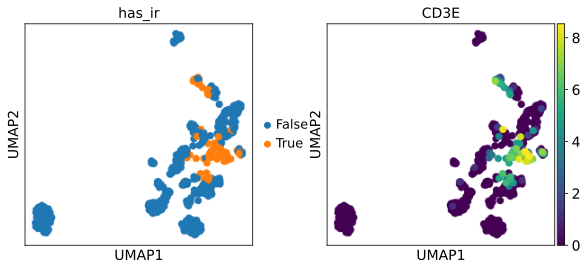

In [18]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_ir", "CD3E"])

In [19]:
# define sample metadata. Usually read from a file.
samples = {
    "C144": {"group": "mild"},
    "C146": {"group": "severe"},
    "C149": {"group": "healthy control"},
}

In [20]:
# Create a list of AnnData objects (one for each sample)
adatas = []
for sample, sample_meta in samples.items():
    gex_file = glob(f"example_data/liao-2019-covid19/*{sample}*.h5")[0]
    tcr_file = glob(f"example_data/liao-2019-covid19/*{sample}*.csv.gz")[0]
    adata = sc.read_10x_h5(gex_file)
    adata_tcr = ir.io.read_10x_vdj(tcr_file)
    ir.pp.merge_with_ir(adata, adata_tcr)
    adata.obs["sample"] = sample
    adata.obs["group"] = sample_meta["group"]
    # concatenation only works with unique gene names
    adata.var_names_make_unique()
    adatas.append(adata)

In [21]:
# Merge anndata objects
adata = adatas[0].concatenate(adatas[1:])

The data is now integrated in a single object.
Again, the detected TCRs coincide with `CD3E` gene expression.
We clearly observe batch effects between the samples -- for a meaningful downstream analysis further
processing steps such as highly-variable gene filtering and batch correction are necessary.

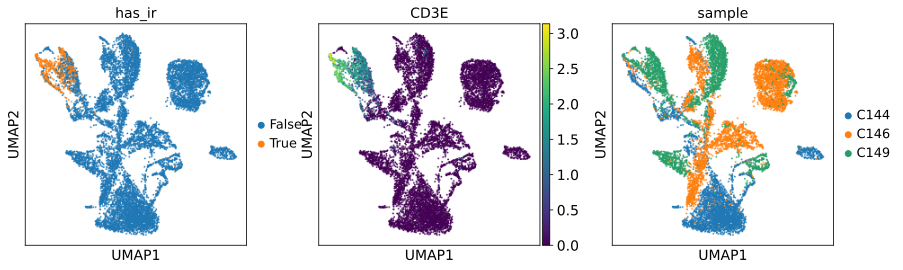

In [22]:
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_ir", "CD3E", "sample"])